# **Denoiser approximation of a mathematical filter model (FIR and IIR case study)**

The goal is to show that a neural network can learn to approximate a filter's behaviour based on its time and frequency response analysis

## **Mathematical modelling of an FIR filter**

- Time domain representation:
$$ y[n] = \sum_{k=0}^{M-1} h[k] \cdot x[n-k] $$
where
- $y[n]$ is the output signal
- $x[n-k]$ is the input signal delayed by $k$ samples
- $h[k]$ is the filter coefficients
- $M$ is the number of coefficients

- Frequency domain representation: By taking the discrete time fourier transform (DTFT) of the impulse reponse $h[n]$:
$$ H(e^{j\omega}) = \sum_{k=0}^{M-1} h[k] \cdot e^{-j\omega k}$$


## **Neural Network Approximation of FIR filters**
Use of a 1D convolutional neural network (1D CNN) for FIR filters

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

import scipy.signal as signal

In [2]:
# a simple fir low pass filter using moving average
coeffs = np.array([1/3, 1/3, 1/3])
coeffs.shape

(3,)

Text(0, 0.5, 'Phase')

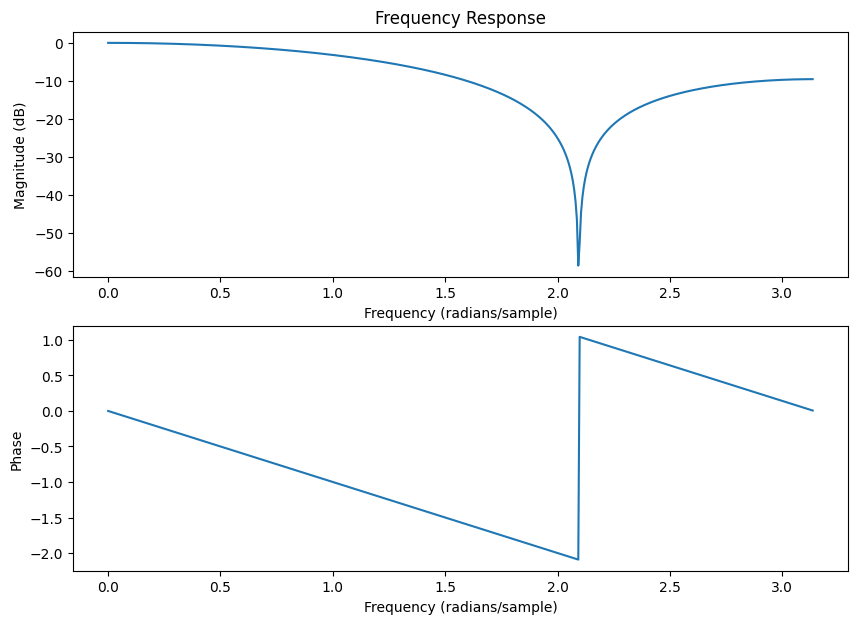

In [3]:
w, H = signal.freqz(coeffs)
H_db = 20*np.log10(np.abs(H))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(2, 1, 1)
ax.plot(w, H_db)
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Frequency Response')

ax = fig.add_subplot(2, 1, 2)
ax.plot(w, np.arctan2(np.imag(H), np.real(H)))
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Phase')

In [4]:
# denoiser module is given by the following equations
# y = {0, if |x| <= tau, sgn(x) * (|x| - tau), otherwise}
# where tau is the threshold value given as 2 * beta
# beta is output of the global average pooling layer

class Denoiser(nn.Module):
    def __init__(self, in_feat=2, seq_len=128):
        super(Denoiser, self).__init__()
        self.gap = nn.AvgPool1d(seq_len)
        self.fc1 = nn.Linear(in_feat, in_feat)
        self.bn = nn.BatchNorm1d(in_feat)
        self.fc2 = nn.Linear(in_feat, in_feat)

    def forward(self, x):
        tau = self.gap(x).squeeze(-1)
        tau = F.relu(self.fc1(tau))
        tau = self.bn(tau)
        tau = 2 * F.sigmoid(self.fc2(tau)).unsqueeze(-1)
        y = torch.where(torch.abs(x) <= tau, torch.tensor(0.0),
                        torch.sign(x) * (torch.abs(x) - tau))
        return y

In [94]:
class thresholdModule(nn.Module):
    def __init__(self, in_feat=16, hidden_feat=256):
        super(thresholdModule, self).__init__()
        self.gap = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(in_feat, hidden_feat)
        self.bn = nn.BatchNorm1d(hidden_feat)
        self.fc2 = nn.Linear(hidden_feat, in_feat)

    def forward(self, x):  # B x feat x 2 x 128
        # B x feat x 1 x 1 -> B x feat
        tau = self.gap(x).squeeze(-1).squeeze(-1)
        tau = F.relu(self.fc1(tau))  # B x 256
        tau = self.bn(tau)  # B x 256
        tau = 2 * F.sigmoid(self.fc2(tau))  # B x feat
        tau = tau.unsqueeze(-1).unsqueeze(-1)  # B x feat x 1 x 1
        y = torch.where(torch.abs(x) <= tau, torch.tensor(0.0),
                        torch.sign(x) * (torch.abs(x) - tau))
        return y


class Denoiser2(nn.Module):
    def __init__(self, in_feat=1, hidden_feat=16, n_chan=2, seq_len=128):
        super(Denoiser2, self).__init__()
        self.bn = nn.BatchNorm2d(in_feat)
        self.conv = nn.Conv2d(in_feat, hidden_feat,
                              kernel_size=(n_chan, 3), padding="same")
        self.threshold = thresholdModule(hidden_feat, seq_len * n_chan)
        self.proj = nn.Conv2d(hidden_feat, in_feat, kernel_size=1)

    def forward(self, x):  # B x feat x 2 x 128
        x = self.bn(x)
        x = F.relu(self.conv(x))
        y = self.threshold(x)
        return self.proj(y)

In [52]:
# toy data set
X_train = torch.randn(100, 2, 128)
y_train_i = torch.tensor(
    np.array([np.convolve(x[0], coeffs, mode='same') for x in X_train]))
y_train_q = torch.tensor(
    np.array([np.convolve(x[1], coeffs, mode='same') for x in X_train]))
X_train = X_train.unsqueeze(1)
y_train = torch.stack([y_train_i, y_train_q], dim=1).unsqueeze(1).float()

X_val = torch.randn(30, 2, 128)
y_val_i = torch.tensor(
    np.array([np.convolve(x[0], coeffs, mode='same') for x in X_val]))
y_val_q = torch.tensor(
    np.array([np.convolve(x[1], coeffs, mode='same') for x in X_val]))
X_val = X_val.unsqueeze(1)
y_val = torch.stack([y_val_i, y_val_q], dim=1).unsqueeze(1).float()

In [53]:
X_train.shape, y_train.shape

(torch.Size([100, 1, 2, 128]), torch.Size([100, 1, 2, 128]))

In [54]:
X_train.dtype, y_train.dtype

(torch.float32, torch.float32)

In [8]:
EPOCHS = 100

In [ ]:
model = Denoiser2()
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()

model.train()
history = {'train_loss': [], 'val_loss': []}
for epoch in range(EPOCHS):
    optim.zero_grad()
    y_pred = model(X_train)
    loss = criterion(y_pred, y_train)
    loss.backward()
    optim.step()

    with torch.no_grad():
        y_val_pred = model(X_val)
        val_loss = criterion(y_val_pred, y_val)
    history['train_loss'].append(loss.item())
    history['val_loss'].append(val_loss.item())

    if (epoch + 1) % 10 == 0:
        print(
            f'Epoch {epoch+1}/{EPOCHS}, Loss: {loss.item():.4f}, Validation Loss: {val_loss.item():.4f}')

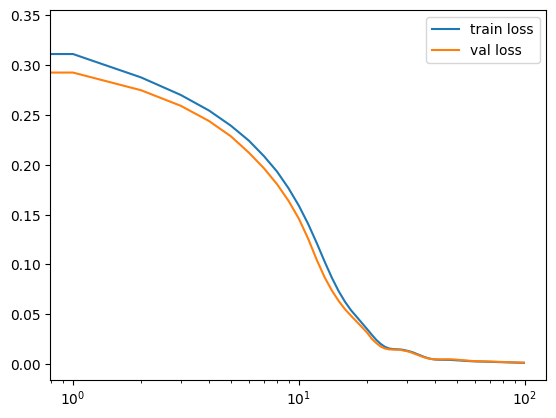

In [96]:
plt.semilogx(history['train_loss'], label='train loss')
plt.semilogx(history['val_loss'], label='val loss')
plt.legend()

## **Analysis of trained model**

In [97]:
X_test = torch.randn(10, 2, 128)
y_test_i = torch.tensor(
    np.array([np.convolve(x[0], coeffs, mode='same') for x in X_test]))
y_test_q = torch.tensor(
    np.array([np.convolve(x[1], coeffs, mode='same') for x in X_test]))
y_test = torch.stack([y_test_i, y_test_q], dim=1).unsqueeze(1).float()
X_test = X_test.unsqueeze(1)

X_test.shape, y_test.shape

(torch.Size([10, 1, 2, 128]), torch.Size([10, 1, 2, 128]))

(0.0, 3.141592653589793)

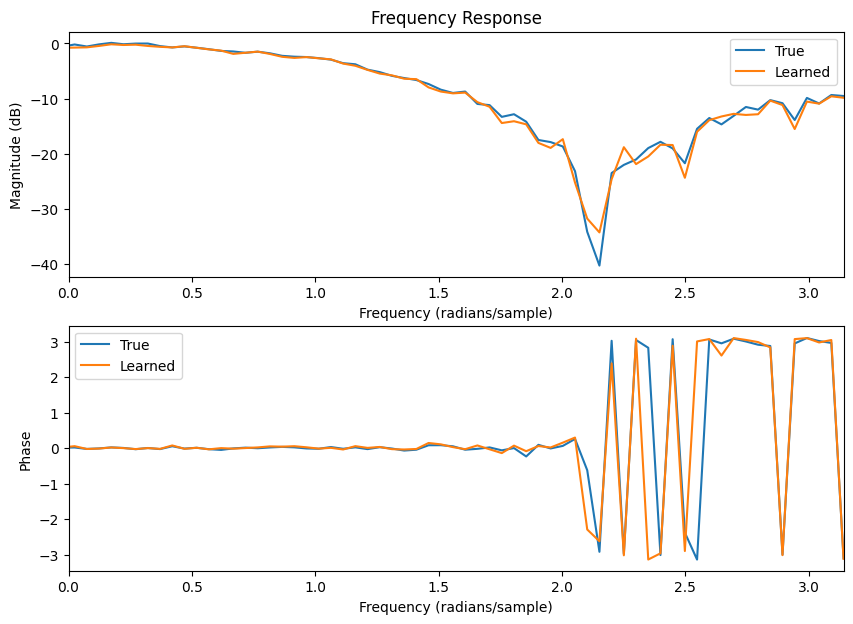

In [102]:
# plot the frequency response by comparing the input and output
y_test_pred = model(X_test).detach()


X_fft = torch.fft.fftshift(torch.fft.fft(
    X_test[:, :, 0] + 1j * X_test[:, :, 1], dim=-1), dim=-1)
y_fft = torch.fft.fftshift(torch.fft.fft(
    y_test[:, :, 0] + 1j * y_test[:, :, 1], dim=-1), dim=-1)
y_pred_fft = torch.fft.fftshift(torch.fft.fft(
    y_test_pred[:, :, 0] + 1j * y_test_pred[:, :, 1], dim=-1), dim=-1)

H = (y_fft / X_fft).squeeze(1).mean(dim=0)
H_pred = (y_pred_fft / X_fft).squeeze(1).mean(dim=0)

H_db = 20 * torch.log10(torch.abs(H))
H_pred_db = 20 * torch.log10(torch.abs(H_pred))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(2, 1, 1)
w = torch.linspace(-np.pi, np.pi, 128)
ax.plot(w, H_db.numpy(), label='True')
ax.plot(w, H_pred_db.detach().numpy(), label='Learned')
ax.legend()
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Frequency Response')
ax.set_xlim(0, np.pi)

ax = fig.add_subplot(2, 1, 2)
ax.plot(w, torch.arctan2(H.imag, H.real), label='True')
ax.plot(w, torch.arctan2(H_pred.imag, H_pred.real), label='Learned')
ax.legend()
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Phase')
ax.set_xlim(0, np.pi)

## **Data generation**

We will test the idea of the ablation study of the denoiser module in the the TDRNN network proposed by [https://www.techrxiv.org/doi/pdf/10.36227/techrxiv.23632308.v1](https://www.techrxiv.org/doi/pdf/10.36227/techrxiv.23632308.v1) by observing the frequency reponse on these signals (qpsk and ofdm on qpsk symbols). These signal are defined by $\mathbb{C}^{40960}$

In [103]:
import tensorflow as tf

# local imports
import comm_utils as comm

In [104]:
sps = 16
ofdm_symbol_len = 80  # 64 subcarriers + 16 cyclic prefix
sig_len = 40_960

In [105]:
def get_db(p): return 10*np.log10(p)
def get_pow(s): return np.mean(np.abs(s)**2, axis=-1)
def get_sinr(s, i): return get_pow(s)/get_pow(i)


def get_sinr_db(s, i): return get_db(get_sinr(s, i))


def generate_train_mixture(soi_type, nexamples):
    if soi_type == 'QPSK':
        gen_soi = comm.generate_qpsk_signal
        num_symbols = sig_len // sps
    elif soi_type == 'QPSK_OFDM':
        gen_soi = comm.generate_ofdm_signal
        num_symbols = sig_len // ofdm_symbol_len
    else:
        raise NotImplementedError

    sinr_db = tf.random.uniform(
        shape=(nexamples, 1), minval=-20, maxval=20, dtype=tf.float32)
    gain_linear = tf.pow(10.0, -0.5 * sinr_db / 10.0)
    gain_complex = tf.complex(gain_linear, tf.zeros_like(gain_linear))
    phase = tf.random.uniform(
        shape=(nexamples, 1), minval=-np.pi, maxval=np.pi, dtype=tf.float32)
    phase_complex = tf.complex(phase, tf.zeros_like(gain_linear))
    gain_phasor = gain_complex * tf.math.exp(1j * phase_complex)

    soi, msg_bits = gen_soi(nexamples, num_symbols)
    noise = tf.random.normal(
        shape=(nexamples, sig_len), mean=0.0, stddev=1.0)
    noise_complex = gain_phasor * tf.complex(noise, noise)
    sig_mixed = soi + noise_complex
    return dict(
        soi=soi,
        sig_mixed=sig_mixed,
        actual_sinr_db=get_sinr_db(soi, noise_complex),
        expected_sinr_db=sinr_db,
        msg_bits=msg_bits
    )

In [106]:
result = generate_train_mixture('QPSK', 7000)

In [107]:
soi = result.get('soi').numpy()
sig_mixed = result.get('sig_mixed').numpy()
actual_sinr_db = result.get('actual_sinr_db')
expected_sinr_db = result.get('expected_sinr_db').numpy()
msg_bits = result.get('msg_bits').numpy()

In [108]:
soi.shape, sig_mixed.shape, actual_sinr_db.shape, expected_sinr_db.shape, msg_bits.shape

((7000, 40960), (7000, 40960), (7000,), (7000, 1), (7000, 5120))

In [109]:
actual_sinr_db

array([ -2.0292785,  -3.9466133, -17.828028 , ...,  -9.759807 ,
         3.7073836,   3.13007  ], dtype=float32)

In [110]:
def plot_signal(soi, sig_mixed, fig=None):
    if fig is None:
        fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(2, 1, 1)
    ax.plot(sig_mixed.real, label='sig_mixed')
    ax.plot(soi.real, label='soi')
    ax.legend()
    ax.set_xlim(3000, 4024)

    ax = fig.add_subplot(2, 1, 2)
    signal_slices = torch.tensor(sig_mixed).unfold(0, 1024, 512)
    windowed_slices = signal_slices * torch.hann_window(1024)
    Sxx = torch.fft.fftshift(torch.fft.fft(windowed_slices, dim=-1), dim=-1)
    ax.imshow(10*torch.log10(torch.abs(Sxx)**2).T, aspect='auto')
    ax.set_xlabel('Time')
    ax.set_ylabel('Frequency')

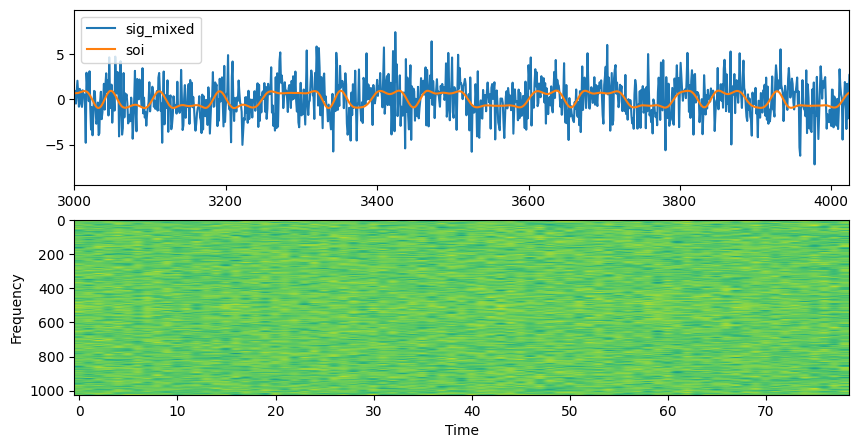

In [111]:
plot_signal(soi[2], sig_mixed[2])

In [112]:
from torch.utils.data import Dataset, DataLoader, random_split


class MixtureDataset(Dataset):
    def __init__(self, sig_mixed, soi, transform_mixed=None, transform_soi=None):
        self.sig_mixed = sig_mixed
        self.soi = soi
        self.transform_mixed = transform_mixed
        self.transform_soi = transform_soi

    def __len__(self):
        return len(self.sig_mixed)

    def __getitem__(self, idx):
        x = self.sig_mixed[idx]
        y = self.soi[idx]

        if self.transform_mixed:
            x = self.transform_mixed(x)
        elif isinstance(x, np.ndarray):
            x = torch.tensor(x)
        if self.transform_soi:
            y = self.transform_soi(y)
        elif isinstance(y, np.ndarray):
            y = torch.tensor(y)
        return x, y

In [113]:
from torchvision.transforms import Compose, Lambda

transform = Compose([
    Lambda(lambda x: torch.tensor(x, dtype=torch.complex64)),
    Lambda(lambda x: torch.stack([x.real, x.imag],
                                 axis=0) if x.dtype == torch.complex64 else x),
    Lambda(lambda x: x.unsqueeze(0))
])

train_ds, val_ds = random_split(MixtureDataset(
    sig_mixed, soi, transform_mixed=transform, transform_soi=transform), [0.6, 0.4])

In [114]:
train_dl = DataLoader(train_ds, batch_size=32, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=32, shuffle=False)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Denoiser2(seq_len=40960).to(device)
optim = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = nn.MSELoss()
model.train()

history = {'train_loss': [], 'val_loss': []}

for epoch in range(EPOCHS):
    running_tloss = 0.0
    running_vloss = 0.0
    for x, y in train_dl:
        x, y = x.to(device), y.to(device)
        optim.zero_grad()
        y_pred = model(x)
        loss = criterion(y_pred, y)
        loss.backward()
        running_tloss += loss.item()
        optim.step()
    avg_tloss = running_tloss / len(train_dl)

    with torch.no_grad():
        for x, y in val_dl:
            x, y = x.to(device), y.to(device)
            y_val_pred = model(x)
            val_loss = criterion(y_val_pred, y)
            running_vloss += val_loss.item()
    avg_vloss = running_vloss / len(val_dl)
    history['train_loss'].append(avg_tloss)
    history['val_loss'].append(avg_vloss)
    if (epoch + 1) % 10 == 0:
        print(
            f'Epoch {epoch+1}/{EPOCHS}, Loss: {avg_tloss:.4f}, Validation Loss: {avg_vloss:.4f}')

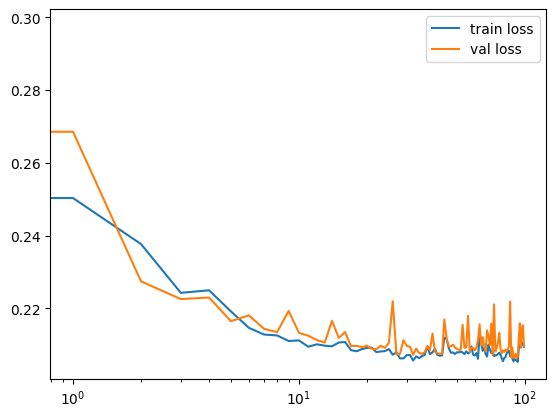

In [116]:
plt.semilogx(history['train_loss'], label='train loss')
plt.semilogx(history['val_loss'], label='val loss')
plt.legend()

## **Analysis of trained model**

In [117]:
model

Denoiser2(
  (bn): BatchNorm2d(1, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv): Conv2d(1, 16, kernel_size=(2, 3), stride=(1, 1), padding=same)
  (threshold): thresholdModule(
    (gap): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc1): Linear(in_features=16, out_features=81920, bias=True)
    (bn): BatchNorm1d(81920, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=81920, out_features=16, bias=True)
  )
  (proj): Conv2d(16, 1, kernel_size=(1, 1), stride=(1, 1))
)

In [118]:
'The model has ' + str(sum(p.numel() for p in model.parameters()
                       if p.requires_grad)) + ' parameters'

'The model has 2867347 parameters'

In [119]:
test_data = generate_train_mixture('QPSK', 5)
soi_test = test_data.get('soi').numpy()
sig_mixed_test = test_data.get('sig_mixed').numpy()
sinr_db_test = test_data.get('actual_sinr_db')
msg_bits_test = test_data.get('msg_bits').numpy()

In [120]:
soi_test.shape, sig_mixed_test.shape, sinr_db_test.shape, msg_bits_test.shape

((5, 40960), (5, 40960), (5,), (5, 5120))

In [121]:
sinr_db_test

array([  5.8325853,   2.0880816, -20.719143 , -18.825294 ,  -4.312825 ],
      dtype=float32)

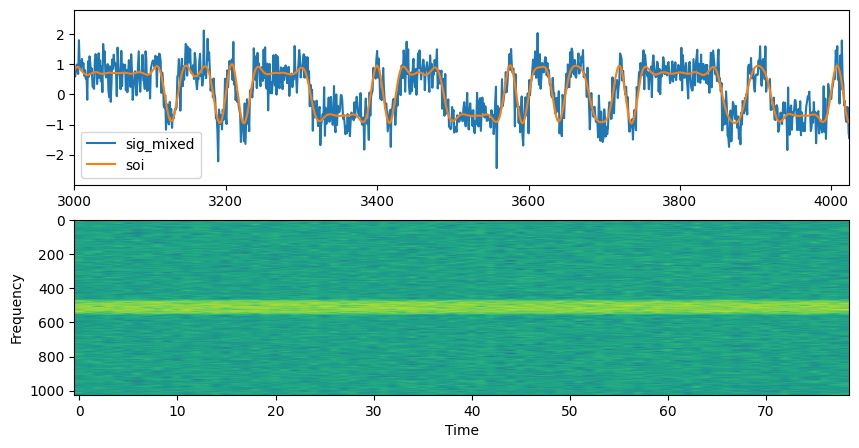

In [122]:
y, x = soi_test[0], sig_mixed_test[0]
plot_signal(y, x)

In [123]:
model.eval()

x_preprocessed = transform(x).unsqueeze(0).to(device)
y_hat = model(x_preprocessed).cpu().detach().numpy()
y_hat.shape

(1, 1, 2, 40960)

(3000.0, 4024.0)

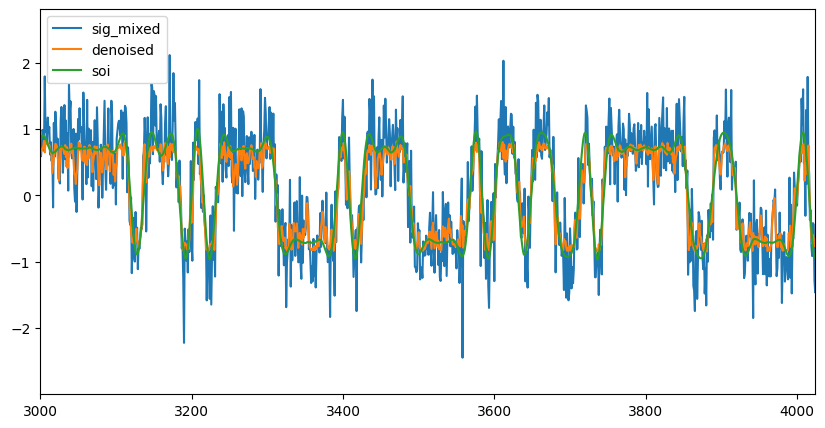

In [125]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x.real, label='sig_mixed')
ax.plot(y_hat[0][0][0], label='denoised')
ax.plot(y.real, label='soi')
ax.legend()
ax.set_xlim(3000, 4024)

(0.0, 3.141592653589793)

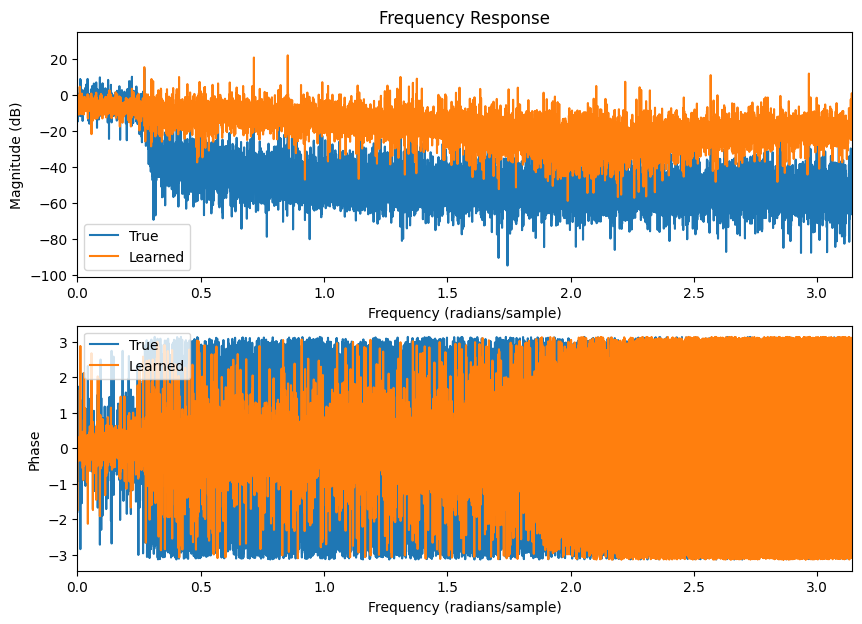

In [131]:
# plot the frequency response by comparing the input and output
X_mixed_test = torch.stack([transform(st) for st in sig_mixed_test])
y_soi_test = torch.stack([transform(st) for st in soi_test])
y_soi_pred = model(X_mixed_test.to(device)).detach().cpu()


X_fft = torch.fft.fftshift(torch.fft.fft(
    X_mixed_test[:, :, 0] + 1j * X_mixed_test[:, :, 1], dim=-1), dim=-1)
y_fft = torch.fft.fftshift(torch.fft.fft(
    y_soi_test[:, :, 0] + 1j * y_soi_test[:, :, 1], dim=-1), dim=-1)
y_pred_fft = torch.fft.fftshift(torch.fft.fft(
    y_soi_pred[:, :, 0] + 1j * y_soi_pred[:, :, 1], dim=-1), dim=-1)

H = (y_fft / X_fft).squeeze(1).mean(dim=0)
H_pred = (y_pred_fft / X_fft).squeeze(1).mean(dim=0)

H_db = 20 * torch.log10(torch.abs(H))
H_pred_db = 20 * torch.log10(torch.abs(H_pred))

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(2, 1, 1)
w = torch.linspace(-np.pi, np.pi, 40960)
ax.plot(w, H_db.numpy(), label='True')
ax.plot(w, H_pred_db.detach().numpy(), label='Learned')
ax.legend()
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Magnitude (dB)')
ax.set_title('Frequency Response')
ax.set_xlim(0, np.pi)

ax = fig.add_subplot(2, 1, 2)
ax.plot(w, torch.arctan2(H.imag, H.real), label='True')
ax.plot(w, torch.arctan2(H_pred.imag, H_pred.real), label='Learned')
ax.legend()
ax.set_xlabel('Frequency (radians/sample)')
ax.set_ylabel('Phase')
ax.set_xlim(0, np.pi)